# Drone 1: Hyper-parameters Tuning

## Introduction: Approach to Tune Classifiers 

Tuning a classifier is a very time-consuming process, even with the help of random search algorithm. Thus, in this project, we use the following approach <font color=blue>[1]</font> to tune the hyper-parameters for both random forest and gradient boosting classifiers:

- First, we use grid search to find out a certain number of etimators. The number of estimators selected should be giving a relatively good cross-validation score, as well as allowing our systems to work fairly fast. Please be noted, this value is not necessarily the one that will be used in the final model.


- Next, we tune max_depth and num_sample_splits as a combination. Then, we move on to select the optimun max_features.


- Finally, with max_depth, num_sample_splits and max_features being tuned, we re-focus on picking the number of estimators that gives us the best overall cross-validation score.

For gradient boosting classifiers, parameters n_estimators and learning_rate should follow an inverse relationship. Therefore, we need to adjust learning_rate at the same time when n_estimators is changed.

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.grid_search_utils import *
from utils.data_visualization_utils import *
from utils.metrics_utils import get_confusion_matrix

from utils.data_storage import DataContianer

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/bruce/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# constant variables: name for each drone.
drone1 = "drone1"

## Load Drone 1 Data

In [3]:
# instantiate an object that contains training and test data for drone 1.
drone1_gyro_data = DataContianer(drone1, 'gyro', 4)

In [4]:
X_train_d1 = drone1_gyro_data.X_train_transformed
y_train_d1 = drone1_gyro_data.y_train_transformed
X_test_d1 = drone1_gyro_data.X_test_transformed
y_test_d1 = drone1_gyro_data.y_test_transformed

## (1) Random Forest

#### Baseline Model

Let's get a baseline random forest classifier without tuning.

In [5]:
rf_baseline_d1 = RandomForestClassifier(random_state = 13)

In [6]:
report_model_score(rf_baseline_d1, X_train_d1, y_train_d1)

Model Report: 
Mean cv score: 0.895 +/- std: 0.018


The mean cv score for our baseline model is <font color=blue> 0.895 </font>, with a standard deviation of <font color=blue> 0.018 </font>.

Then, let's look at the confusion matrix.

In [7]:
_ = rf_baseline_d1.fit(X_train_d1, y_train_d1)

### Visualize Confusion Matrix

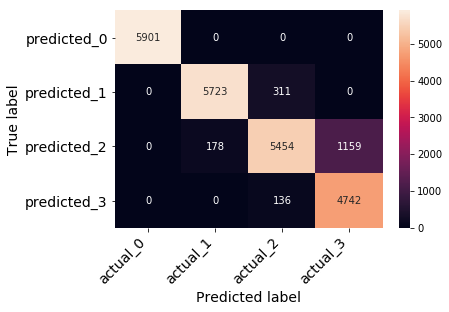

In [8]:
y_pred_d1_rf = rf_baseline_d1.predict(X_test_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_rf, y_test_d1))

### Test Accuracy

In [9]:
print('The test accuracy for baseline model (rf) is {:.3f}'.
      format(rf_baseline_d1.score(X_test_d1, y_test_d1)))

The test accuracy for baseline model (rf) is 0.924


## Hyper-parameters Tuning

Before we start with setting with tuning the number of estimators, we picked the following default values for other hyper-parameters:
- min_samples_split = 500
- min_samples_leaf = 40
- max_depth = 8
- max_features = 'sqrt'
All the hyper-parameters listed above will be tuned later if necessary. 

We also set the random state to 13.

### Step 1: Finding the best initial number of estimators

In [10]:
rf_d1 = RandomForestClassifier(min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt', random_state=13)
param_test1_rf_d2 = {"n_estimators": np.arange(20, 81, 20)}

In [11]:
grid_search = GridSearchCV(rf_d1, param_grid=param_test1_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [12]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8962, Standard Deviation: 0.0206
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.8962, Standard Deviation: 0.0206
Parameters: {'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.8957, Standard Deviation: 0.0203
Parameters: {'n_estimators': 40}



As we can see from the sumamry above, the best mean validation score is returned when n_estimators is 60 or 80. This also means that a higher number of estimators could give us a better result. Thus, further tuning is required for this parameter later.

### Step 2: Tuning max_depth, min_samples_split, min_samples_leaf and max_features

In [23]:
rf_d1 = RandomForestClassifier(n_estimators=80, min_samples_leaf=50, max_features='sqrt', random_state=13)

param_test2_rf_d2 = {
    "max_depth": range(5, 16, 3),
    "min_samples_split": range(200, 1000, 200)
}

In [24]:
grid_search = GridSearchCV(rf_d1, param_grid=param_test2_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [25]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9040, Standard Deviation: 0.0148
Parameters: {'max_depth': 14, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.9023, Standard Deviation: 0.0174
Parameters: {'max_depth': 11, 'min_samples_split': 200}

Model with rank: 3
Mean validation score: 0.9016, Standard Deviation: 0.0169
Parameters: {'max_depth': 11, 'min_samples_split': 400}

Model with rank: 4
Mean validation score: 0.9015, Standard Deviation: 0.0167
Parameters: {'max_depth': 14, 'min_samples_split': 400}

Model with rank: 5
Mean validation score: 0.8985, Standard Deviation: 0.0187
Parameters: {'max_depth': 14, 'min_samples_split': 600}



The different combinations of max_depth and min_samples_split, in terms of their values, show us some valueable information.

First, the value of max_depth should be 14. 

Second, we should try different values for min_samples_split that are lower than 200.

Thus, in the next round of grid search, we will set max_depth to 14 and test <b>min_samples_split</b> along with <b>min_samples_leaf</b>.

In [26]:
rf_d1 = RandomForestClassifier(n_estimators=80, max_features='sqrt', max_depth=14, random_state=13)

param_test3_rf_d2 = {
    "min_samples_leaf": range(30, 71, 10),
    "min_samples_split": range(100, 200, 20)
}

In [27]:
grid_search = GridSearchCV(rf_d1, param_grid=param_test3_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [28]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9046, Standard Deviation: 0.0144
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 140}

Model with rank: 2
Mean validation score: 0.9042, Standard Deviation: 0.0154
Parameters: {'min_samples_leaf': 40, 'min_samples_split': 180}

Model with rank: 3
Mean validation score: 0.9042, Standard Deviation: 0.0152
Parameters: {'min_samples_leaf': 60, 'min_samples_split': 160}

Model with rank: 4
Mean validation score: 0.9042, Standard Deviation: 0.0167
Parameters: {'min_samples_leaf': 30, 'min_samples_split': 100}

Model with rank: 5
Mean validation score: 0.9041, Standard Deviation: 0.0158
Parameters: {'min_samples_leaf': 60, 'min_samples_split': 140}



After we tuned min_samples_leaf and min_samples_split as a combination, the cv score only got increased by 0.06%, which is very insignificant.

In [32]:
rf_d1 = RandomForestClassifier(n_estimators=80, min_samples_split=140, min_samples_leaf=50,
                               max_depth=14, random_state=13)

param_test4_rf_d2 = {
    "max_features": range(6, 17, 2)
}

In [33]:
grid_search = GridSearchCV(rf_d1, param_grid=param_test4_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [34]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9047, Standard Deviation: 0.0157
Parameters: {'max_features': 10}

Model with rank: 2
Mean validation score: 0.9046, Standard Deviation: 0.0144
Parameters: {'max_features': 6}

Model with rank: 3
Mean validation score: 0.9037, Standard Deviation: 0.0148
Parameters: {'max_features': 12}

Model with rank: 4
Mean validation score: 0.9029, Standard Deviation: 0.0163
Parameters: {'max_features': 8}

Model with rank: 5
Mean validation score: 0.9020, Standard Deviation: 0.0153
Parameters: {'max_features': 16}



Setting max_features at 10 only increased mean cv score by 0.01%. 

In [35]:
rf_d1 = RandomForestClassifier(n_estimators=80, max_features=10, min_samples_split=140, min_samples_leaf=50,
                               max_depth=14, random_state=13)

param_test5_rf_d2 = {
    "n_estimators": range(80, 200, 20)
}

In [36]:
grid_search = GridSearchCV(rf_d1, param_grid=param_test5_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [37]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9048, Standard Deviation: 0.0155
Parameters: {'n_estimators': 120}

Model with rank: 2
Mean validation score: 0.9047, Standard Deviation: 0.0157
Parameters: {'n_estimators': 80}

Model with rank: 3
Mean validation score: 0.9047, Standard Deviation: 0.0154
Parameters: {'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.9046, Standard Deviation: 0.0156
Parameters: {'n_estimators': 160}

Model with rank: 5
Mean validation score: 0.9046, Standard Deviation: 0.0157
Parameters: {'n_estimators': 140}



If we increased the number of estimators from 80 to 120, the mean cv score was not increased significantly. According to occam's razor law, we should choose 80 instead of 120.

## Final Random Forest Model, Drone 1

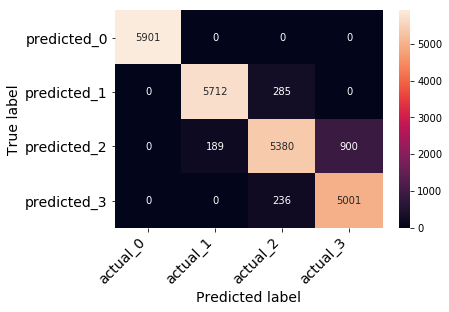

In [40]:
rf_d1_final = rf_d1 = RandomForestClassifier(n_estimators=80, min_samples_split=140, min_samples_leaf=50,
                               max_depth=14, max_features=10, random_state=13)

y_pred_d1_rf = rf_d1_final.predict(X_test_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_rf, y_test_d1))

In [43]:
print('The test accuracy for final model (rf) is {:.4f}'.
      format(rf_d1_final.score(X_test_d1, y_test_d1)))

The test accuracy for baseline model (rf) is 0.9318


The overall accuracy is increased from 92% to 93.18%, which is very insignificant. Judging from the confusion matrix above, the improvement is almost negelectable. Following, we decided to go with occam's razor law and use the <b>default model</b> from sklearn as the final random forest model for classifing winde speed. 

## (1) Gradient Boosting

### Baseline Model

In [13]:
gb_baseline_d1 = GradientBoostingClassifier(random_state = 13)

In [14]:
report_model_score(gb_baseline_d1, X_train_d1, y_train_d1)

Model Report: 
Mean cv score: 0.904 +/- std: 0.015


In [ ]:
_ = gb_baseline_d1.fit(X_train_d1, y_train_d1)

In [ ]:
y_pred_d1_gb = gb_baseline_d1.predict(X_test_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_gb, y_test_d1))

In [ ]:
print('The test accuracy for baseline model (gb) is {:.3f}'.
      format(gb_baseline_d1.score(X_test_d1, y_test_d1)))

Right off the bat, the default gradient boosting model gave us a slightly better model than random forest. From the confusion matrix of random forest, we can see that it has a hard time differentiating  class 2 and 3. Gradient boosting performed slight better on telling the difference between class 2 and 3.

## Hyper-parameters Tuning

#### Step 1: Finding the best initial combination of n_estimators and learning_rate

In [10]:
gb_d1 = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                    max_depth=8, max_features='sqrt', subsample=0.8, random_state=13)

param_test1_gb_d1 = {'n_estimators':range(20,81,20)}

In [11]:
grid_search = GridSearchCV(gb_d1, param_grid=param_test1_gb_d1, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [12]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9069, Standard Deviation: 0.0151
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.9060, Standard Deviation: 0.0149
Parameters: {'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.9057, Standard Deviation: 0.0151
Parameters: {'n_estimators': 40}



When there are 80 estimators with learning rate set to 0.1, the mean cv score got increased by 0.29%. Thus, we picked 80 for n_estimators and would come back to tuning n_estimators and learning_rate as a combination in the end.

In [16]:
gb_d1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=50,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test2_gb_d1 = {
    "max_depth": range(5, 15, 3),
    "min_samples_split": range(200, 601, 200)
}

In [17]:
grid_search = GridSearchCV(gb_d1, param_grid=param_test2_gb_d1, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [18]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9100, Standard Deviation: 0.0137
Parameters: {'max_depth': 11, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.9083, Standard Deviation: 0.0148
Parameters: {'max_depth': 14, 'min_samples_split': 800}

Model with rank: 3
Mean validation score: 0.9083, Standard Deviation: 0.0152
Parameters: {'max_depth': 8, 'min_samples_split': 600}



Here, the combination that imcreased the mean cv is when max_depth is 11 and min_samples_split is 200. Another thing worth pointing out is that the two values are relatively small compared to the arraies of numbers in the parameter grid, which agrees with occam's razor law.

In [19]:
gb_d1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                   min_samples_split = 200,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test3_gb_d1 = {
    "min_samples_leaf": range(30,71,10)
}

In [20]:
grid_search = GridSearchCV(gb_d1, param_grid=param_test3_gb_d1, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [21]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9100, Standard Deviation: 0.0137
Parameters: {'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.9091, Standard Deviation: 0.0138
Parameters: {'min_samples_leaf': 60}

Model with rank: 3
Mean validation score: 0.9088, Standard Deviation: 0.0149
Parameters: {'min_samples_leaf': 30}



The value of min_samples_leaf that give the best mean cv score is 50, which is also the default value.

In [26]:
gb_d1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                   min_samples_split = 200,
                                   min_samples_leaf=50, subsample=0.8, random_state=13)

param_test4_gb_d1 = {
    "max_features": range(6, 17, 2)
}

In [27]:
grid_search = GridSearchCV(gb_d1, param_grid=param_test4_gb_d1, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [28]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9100, Standard Deviation: 0.0137
Parameters: {'max_features': 6}

Model with rank: 2
Mean validation score: 0.9081, Standard Deviation: 0.0153
Parameters: {'max_features': 12}

Model with rank: 3
Mean validation score: 0.9070, Standard Deviation: 0.0145
Parameters: {'max_features': 8}



The default value of max_features in gradient boosting is the square root of the number of features, according to the documentation on sklearn. We also tested other values such as 30% to 40% of the the total number of features. The result above shows that we can use a lower value of max_features and also achieve 91% cv score.

In [29]:
gb_d1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                   min_samples_split=200, max_features=6,
                                   min_samples_leaf=50, random_state=13)

param_test5_gb_d1 = {
    "subsample": [0.6, 0.7, 0.8, 0.9]
}

In [30]:
grid_search = GridSearchCV(gb_d1, param_grid=param_test5_gb_d1, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d1, y_train_d1)

In [31]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9100, Standard Deviation: 0.0137
Parameters: {'subsample': 0.8}

Model with rank: 2
Mean validation score: 0.9091, Standard Deviation: 0.0144
Parameters: {'subsample': 0.6}

Model with rank: 3
Mean validation score: 0.9082, Standard Deviation: 0.0155
Parameters: {'subsample': 0.7}



Tuning subsample does not yield a better mean cv score. According to sklearn, 0.8 is the default number for 'subsample.' This means the default number is sufficient. 

In [35]:
gb_d1_final = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160, max_depth=11,
                                   min_samples_split=200, max_features=6,
                                   min_samples_leaf=50, random_state=13, subsample= 0.8)

In [36]:
report_model_score(gb_d1_final, X_train_d1, y_train_d1)

Model Report: 
Mean cv score: 0.908 +/- std: 0.014


We doubled the number of estimators and lower the learning rate by half. The new combination gave us a slightly decrease in accuracy. Thus, we will choos 80 for n_estimators and 1.0 for learning rate in our final model.

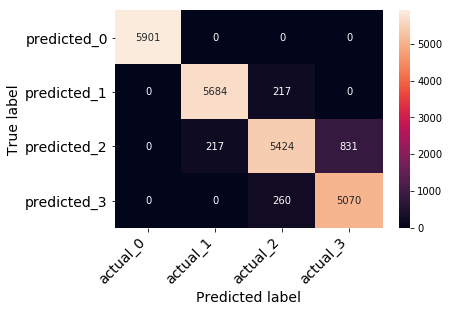

In [37]:
gb_d1_final = grid_search
y_pred_d1_gb = gb_d1_final.predict(X_test_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_gb, y_test_d1))

In [39]:
print('The test accuracy for final model (gb) is {:.4f}'.
      format(gb_d1_final.score(X_test_d1, y_test_d1)))

The test accuracy for final model (gb) is 0.9354


## Summary

The final gradient boosting model did not provide a better accuracy than the default/baseline model on the test set. Moreover, the default model is simplier than the model we trained, which means the final model is a little too complex than what is necessary. 

Similiar to why we chose the final random forest model, we decided to go with the <b>default/baseline model</b>.

# Directional Data

Next, we will be tuning a random forest classifier and a gradient boosting classifier for directional data. In this experiment, the drone underwent air turbulence came from different direction when hovering. The following explains how we classify the labels:
- 0: facing against wind.
- 1: facing away wind.
- 2: wind is blowing at the right side of the drone.
- 3: wind is blowing at the left side of the drone.

## Load Data

In [49]:
# instantiate an object that contains training and test data for drone 1.
drone1_gyro_directional = DataContianer('drone1', 'acc', 4, is_directional=True)

In [50]:
X_train_directional_d1 = drone1_gyro_directional.X_train_transformed
y_train_directional_d1 = drone1_gyro_directional.y_train_transformed
X_test_directional_d1 = drone1_gyro_directional.X_test_transformed
y_test_directional_d1 = drone1_gyro_directional.y_test_transformed

## (1) Random Forest

# Baseline Model

In [51]:
rf_baseline_directional_d1 = RandomForestClassifier(random_state = 13)

In [52]:
report_model_score(rf_baseline_directional_d1, X_train_directional_d1, y_train_directional_d1)

Model Report: 
Mean cv score: 0.885 +/- std: 0.031


In [53]:
_ = rf_baseline_directional_d1.fit(X_train_directional_d1, y_train_directional_d1)

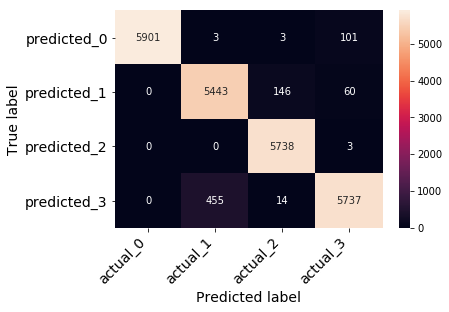

In [54]:
y_pred_d1_rf_directional = rf_baseline_directional_d1.predict(X_test_directional_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_rf_directional, y_test_directional_d1))

In [55]:
print('The test accuracy for baseline model (rf, directional) is {:.3f}'.
      format(rf_baseline_directional_d1.score(X_test_directional_d1, y_test_directional_d1)))

The test accuracy for baseline model (rf, directional) is 0.967


## Hyper-parameters Tuning

#### Step 1: Finding the best initial number of estimators

In [56]:
rf_d1_directional = RandomForestClassifier(min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt', random_state=13)

param_test1_rf_d1_directional = {"n_estimators": np.arange(20, 81, 20)}

In [57]:
grid_search = GridSearchCV(rf_d1_directional, param_grid=param_test1_rf_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1, y_train_directional_d1)

In [58]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8525, Standard Deviation: 0.0569
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.8480, Standard Deviation: 0.0580
Parameters: {'n_estimators': 40}

Model with rank: 3
Mean validation score: 0.8416, Standard Deviation: 0.0641
Parameters: {'n_estimators': 80}



The default values that we picked scored worse than our baseline model. This means the model is under fitted, we can expect to see some values will decrease as the mean cv score goes up.

### Step 2: Tuning max_depth, min_samples_split, min_samples_leaf and max_features

In [61]:
rf_d1_directional = RandomForestClassifier(n_estimators=60, min_samples_leaf=50, max_features='sqrt', random_state=13)

param_test2_rf_d1_directional = {
    "max_depth": range(5, 16, 3),
    "min_samples_split": range(200, 1000, 200)
}

In [62]:
grid_search = GridSearchCV(rf_d1_directional, param_grid=param_test2_rf_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1, y_train_directional_d1)

In [63]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8737, Standard Deviation: 0.0499
Parameters: {'max_depth': 14, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.8721, Standard Deviation: 0.0519
Parameters: {'max_depth': 11, 'min_samples_split': 200}

Model with rank: 3
Mean validation score: 0.8715, Standard Deviation: 0.0480
Parameters: {'max_depth': 14, 'min_samples_split': 400}



The decrease of the value of min_samples_split improved the mean accuracy, which confirmed our spectulation. However, the mean cv score (87%) is still lower than the one basline model provided (88%).

In [64]:
rf_d1_directional = RandomForestClassifier(n_estimators=60, max_features='sqrt', 
                                           max_depth=14, min_samples_split=200, random_state=13)

param_test3_rf_d1_directional = {
    "min_samples_leaf": range(30, 71, 10),
}

In [65]:
grid_search = GridSearchCV(rf_d1_directional, param_grid=param_test3_rf_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1, y_train_directional_d1)

In [66]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8783, Standard Deviation: 0.0462
Parameters: {'min_samples_leaf': 60}

Model with rank: 2
Mean validation score: 0.8778, Standard Deviation: 0.0492
Parameters: {'min_samples_leaf': 40}

Model with rank: 3
Mean validation score: 0.8762, Standard Deviation: 0.0451
Parameters: {'min_samples_leaf': 70}



In [70]:
rf_d1_directional = RandomForestClassifier(n_estimators=60, min_samples_split=200,
                                           min_samples_leaf=60, max_depth=14, random_state=13)

param_test4_rf_d1_directional = {
    "max_features": range(6, 17, 2)
}

In [71]:
grid_search = GridSearchCV(rf_d1_directional, param_grid=param_test4_rf_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1, y_train_directional_d1)

In [72]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9141, Standard Deviation: 0.0264
Parameters: {'max_features': 16}

Model with rank: 2
Mean validation score: 0.9096, Standard Deviation: 0.0324
Parameters: {'max_features': 12}

Model with rank: 3
Mean validation score: 0.9096, Standard Deviation: 0.0289
Parameters: {'max_features': 14}



When max_features is set at 16, the mean cv got boosted to 91% from 87%. This is a hugh improvement and indicates that max_features has a bigger predictive influence.

In [73]:
rf_d1_directional = RandomForestClassifier(n_estimators=60, max_features=16, min_samples_split=200, 
                                           min_samples_leaf=60, max_depth=14, random_state=13)

param_test5_rf_d1_directional = {
    "n_estimators": range(80, 200, 20)
}

In [74]:
grid_search = GridSearchCV(rf_d1_directional, param_grid=param_test5_rf_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1, y_train_directional_d1)

In [75]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9143, Standard Deviation: 0.0271
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.9142, Standard Deviation: 0.0270
Parameters: {'n_estimators': 120}

Model with rank: 3
Mean validation score: 0.9142, Standard Deviation: 0.0270
Parameters: {'n_estimators': 140}



Higher values of n_estimators do not yield better models. Therefore, we set 60 estimators for our final model.

## Final Random Forest Model, Drone 1

In [77]:
rf_d1_directional_final = RandomForestClassifier(n_estimators=60, max_features=16, min_samples_split=200, 
                                           min_samples_leaf=60, max_depth=14, random_state=13)

_ = rf_d1_directional_final.fit(X_train_directional_d1, y_train_directional_d1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=60, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

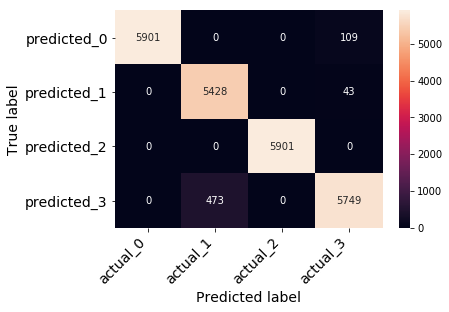

In [78]:
y_pred_d1_rf_directional = rf_d1_directional_final.predict(X_test_directional_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_rf_directional, y_test_directional_d1))

In [79]:
print('The test accuracy for final model (rf, directional) is {:.3f}'.
      format(rf_d1_directional_final.score(X_test_directional_d1, y_test_directional_d1)))

The test accuracy for final model (rf, directional) is 0.974


# Summary

Although the increase in accuracy seems not so significant, which is from 96.7% to 97.4%, we decided to choose the <b>fine tuned model</b>. 

The reason being, comparing the two confusion matrices, the final model cleared a relatively large amount of mis-classifications. 

## (2) Gradient Boosting

## Baseline Model

In [81]:
gb_baseline_directional_d1 = GradientBoostingClassifier(random_state = 13)

In [82]:
report_model_score(gb_baseline_directional_d1, 
                   X_train_directional_d1, 
                   y_train_directional_d1)

Model Report: 
Mean cv score: 0.938 +/- std: 0.015


In [83]:
_ = gb_baseline_directional_d1.fit(X_train_directional_d1,
                                   y_train_directional_d1)

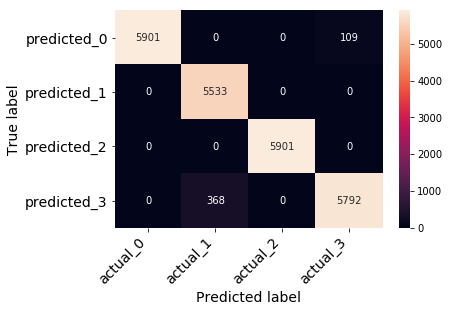

In [84]:
y_pred_d1_gb_directional = gb_baseline_directional_d1.predict(X_test_directional_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_gb_directional,
                                           y_test_directional_d1))

In [85]:
print('The test accuracy for baseline model (gb, directional) is {:.3f}'.
      format(gb_baseline_directional_d1.score(X_test_directional_d1,
                                              y_test_directional_d1)))

The test accuracy for baseline model (gb, directional) is 0.980


Still, right off the bat, gradient boosting classifier got an edge over random forest model. It scored a 93.8% mean cv score and 98% accuracy on test set. Looking at the confusion matrix, we can tell gradient boosting tells the difference between class 1 and class 4 better than random forest. 

## Hyper-parameters Tuning

#### Step 1: Finding the best initial number of estimators

Default values:
- learning_rate=0.1, 
- min_samples_split=500, 
- min_samples_leaf=50,
- max_depth=8, 
- max_features='sqrt', 
- subsample=0.8, 
- random_state=13

In [87]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                    max_depth=8, max_features='sqrt', subsample=0.8, random_state=13)

param_test1_gb_d1_directional = {'n_estimators':range(20,81,20)}

In [88]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test1_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [89]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9250, Standard Deviation: 0.0225
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.9215, Standard Deviation: 0.0238
Parameters: {'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.9138, Standard Deviation: 0.0262
Parameters: {'n_estimators': 40}



We will go with 80 estimators for now.

In [90]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=50,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test2_gb_d1_directional = {
    "max_depth": range(5, 15, 3),
    "min_samples_split": range(200, 601, 200)
}

In [91]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test2_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [92]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9310, Standard Deviation: 0.0193
Parameters: {'max_depth': 5, 'min_samples_split': 600}

Model with rank: 2
Mean validation score: 0.9293, Standard Deviation: 0.0212
Parameters: {'max_depth': 5, 'min_samples_split': 200}

Model with rank: 3
Mean validation score: 0.9286, Standard Deviation: 0.0220
Parameters: {'max_depth': 5, 'min_samples_split': 400}



When the min_samples_split is set at 600, which means there could be a higher value that gives a better result. Thus, in the next round of tuning, we need to re-tune min_samples_split along with min_samples_leaf.

In [97]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
                                            max_depth=5, max_features='sqrt',
                                               subsample=0.8, random_state=13)

param_test3_gb_d1_directional = {
    "min_samples_split": range(600, 1001, 200),
    "min_samples_leaf": range(30,71,10)
}

In [99]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test3_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [100]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9310, Standard Deviation: 0.0193
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 600}

Model with rank: 2
Mean validation score: 0.9309, Standard Deviation: 0.0188
Parameters: {'min_samples_leaf': 30, 'min_samples_split': 600}

Model with rank: 3
Mean validation score: 0.9302, Standard Deviation: 0.0201
Parameters: {'min_samples_leaf': 70, 'min_samples_split': 600}



It turns out that, in our current model setting, 600 is the optimum value for min_samples_split. However, the mean cv score is still 0.07% lower than our baseline model.

In [106]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=5,
                                   min_samples_split=600, min_samples_leaf=50, subsample=0.8,
                                               random_state=13)

param_test4_gb_d1_directional = {
    "max_features": range(6, 17, 2)
}

In [107]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test4_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [108]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9353, Standard Deviation: 0.0161
Parameters: {'max_features': 16}

Model with rank: 2
Mean validation score: 0.9349, Standard Deviation: 0.0162
Parameters: {'max_features': 14}

Model with rank: 3
Mean validation score: 0.9341, Standard Deviation: 0.0158
Parameters: {'max_features': 12}



Same, there could be a higher value of max_featuers that could increase the mean cv score. We have to re-tune max_features in the next round of tuning

In [110]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=5,
                                   min_samples_split=600, min_samples_leaf=50, random_state=13)

param_test5_gb_d1_directional = {
    "max_features": range(16, 21, 2),
    "subsample": [0.6, 0.7, 0.8, 0.9]
}

In [111]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test5_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [112]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9369, Standard Deviation: 0.0141
Parameters: {'max_features': 20, 'subsample': 0.7}

Model with rank: 2
Mean validation score: 0.9369, Standard Deviation: 0.0142
Parameters: {'max_features': 20, 'subsample': 0.6}

Model with rank: 3
Mean validation score: 0.9364, Standard Deviation: 0.0147
Parameters: {'max_features': 18, 'subsample': 0.7}



The results tell us that we only need 70% of the total number of features when building a model. However, we still have to find out if a higher value of max_features could increase cv score.

In [129]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=5,
                                   min_samples_split=600, min_samples_leaf=50, random_state=13,
                                    subsample=0.7)

param_test6_gb_d1_directional = {
    "max_features": range(30, 41, 2)
}

In [130]:
grid_search = GridSearchCV(gb_d1_directional, param_grid=param_test6_gb_d1_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d1,
                    y_train_directional_d1)

In [131]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9379, Standard Deviation: 0.0133
Parameters: {'max_features': 30}

Model with rank: 2
Mean validation score: 0.9379, Standard Deviation: 0.0125
Parameters: {'max_features': 38}

Model with rank: 3
Mean validation score: 0.9373, Standard Deviation: 0.0126
Parameters: {'max_features': 36}



When max_features is 30, the model yield a comparable mean cv score to the baseline model. However, the model is already way too complex compared to the baseline one.

Let's take a look at the final result.

In [126]:
gb_d1_directional = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160, max_depth=5,
                                   min_samples_split=600, min_samples_leaf=50, random_state=13,
                                    subsample=0.7, max_features=30)
_ = gb_d1_directional.fit(X_train_directional_d1,
                     y_train_directional_d1)

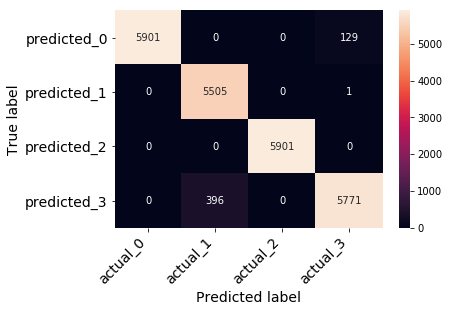

In [127]:
y_pred_d1_gb_directional = gb_d1_directional.predict(X_test_directional_d1)
plot_confusion_matrix(get_confusion_matrix(y_pred_d1_gb_directional,
                                           y_test_directional_d1))

In [128]:
print('The test accuracy for final model (gb, directional) is {:.3f}'.
      format(gb_d1_directional.score(X_test_directional_d1,
                                    y_test_directional_d1)))

The test accuracy for final model (gb, directional) is 0.978


## Summary

The final gradient boosting yield a similiar result to the baseline model. However, the final model is way more complex than the baseline model. Therefore, we decided to go with the <b>baseline model</b> instead of the fine-tuned one.

# Conclusion:

Here are the models we picked for drone 1:
- Wind Detection: <b>default</b> sklearn random forest and <b>default</b> gradient boosting.
- Direction Detection: <b>fine-tuned</b> randome forest and <b>default</b> gradient boosting.

# Works Cited

[1] Jain, Aarshay. “Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python.” Analytics Vidhya, 27 May 2016, www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/.